# A Backdoor Detector for BadNets Trained on the YouTube Face Dataset using the Pruning Defense



## Prepare dataset and model



In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
# change to the working dirctory
%cd /content/drive/MyDrive/EL-GY-9163/lab3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EL-GY-9163/lab3


In [3]:
import tensorflow as tf
import keras
import keras.backend as K
from keras import initializers
from keras.models import Model
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

Mount the google drive. The working directory in my google drive is located at `/content/drive/MyDrive/EL-GY-9163/lab3`.

In [4]:
# load model
model_B = keras.models.load_model('./models/bd_net.h5')
print(model_B.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [4]:
!python eval.py data/cl/valid.h5 data/bd/bd_valid.h5 models/bd_net.h5

2021-12-14 13:59:29.151856: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 13:59:29.695506: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 358187940 exceeds 10% of free system memory.
Clean Classification accuracy: 98.64899974019225
2021-12-14 13:59:40.862748: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 358187940 exceeds 10% of free system memory.
Attack Success Rate: 100.0


In [5]:
# load data 
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

cl_x_test, cl_y_test = data_loader('./data/cl/test.h5')
cl_x_valid, cl_y_valid = data_loader('./data/cl/valid.h5')
bd_x_test, bd_y_test = data_loader('./data/bd/bd_test.h5')
bd_x_valid, bd_y_valid = data_loader('./data/bd/bd_valid.h5')

In [6]:
# evaluate model 
def eval_cca(model, cl_x, cl_y, bd_x, bd_y):
  cl_label_p = np.argmax(model.predict(cl_x), axis=1)
  cl_acc = np.mean(np.equal(cl_label_p, cl_y))*100
  print('Clean Classification accuracy:', cl_acc)
  return cl_acc

def eval_asr(model, cl_x, cl_y, bd_x, bd_y):
  bd_label_p = np.argmax(model.predict(bd_x), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y))*100
  print('Attack Success Rate:', asr)
  return asr

## Prune the badnet

print the result of the last pooling layer under clean validation data, sort the weights in the results.

In [7]:
pool_3 = Model(inputs=model_B.input,
            outputs=model_B.get_layer("pool_3").output)

pool_3_clean_output = np.mean(pool_3.predict(cl_x_valid), axis=0)

idex_clean = np.argsort(np.sum(pool_3_clean_output, axis=(0, 1)))
print(idex_clean)

[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43 58  3 42  1 29 16 56 46
  5  8 11 54 10 28 35 18  4  7 52 57]


Since the pooling layer has no weight nor bias, we could prune the network by pruning the previous layer, which is conv_3.

In [20]:
model_B = keras.models.load_model('./models/bd_net.h5')
layer = model_B.get_layer("conv_3")
weight, bias = layer.get_weights()

c0 = 98.64899974019225
for i in range(len(idex_clean)):
  cur_idex = idex_clean[i]
  weight[:, :, :, cur_idex] = 0
  bias[cur_idex] = 0
  layer.set_weights([weight, bias])
  print('iteration ', i+1)
  c = eval_cca(model_B, cl_x_valid, cl_y_valid, bd_x_valid, bd_y_valid)
  if i+1 == 45:
    model_B.save('/content/drive/MyDrive/EL-GY-9163/lab3/models/gd_2_net.h5')
  elif i+1 == 48:
    model_B.save('/content/drive/MyDrive/EL-GY-9163/lab3/models/gd_4_net.h5')
  elif i+1 == 52:
    model_B.save('/content/drive/MyDrive/EL-GY-9163/lab3/models/gd_10_net.h5')
  elif i+1 == 54:
    model_B.save('/content/drive/MyDrive/EL-GY-9163/lab3/models/gd_30_net.h5')

iteration  1
Clean Classification accuracy: 98.64899974019225
iteration  2
Clean Classification accuracy: 98.64899974019225
iteration  3
Clean Classification accuracy: 98.64899974019225
iteration  4
Clean Classification accuracy: 98.64899974019225
iteration  5
Clean Classification accuracy: 98.64899974019225
iteration  6
Clean Classification accuracy: 98.64899974019225
iteration  7
Clean Classification accuracy: 98.64899974019225
iteration  8
Clean Classification accuracy: 98.64899974019225
iteration  9
Clean Classification accuracy: 98.64899974019225
iteration  10
Clean Classification accuracy: 98.64899974019225
iteration  11
Clean Classification accuracy: 98.64899974019225
iteration  12
Clean Classification accuracy: 98.64899974019225
iteration  13
Clean Classification accuracy: 98.64899974019225
iteration  14
Clean Classification accuracy: 98.64899974019225
iteration  15
Clean Classification accuracy: 98.64899974019225
iteration  16
Clean Classification accuracy: 98.64899974019225
i

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


iteration  46
Clean Classification accuracy: 95.20221702606739
iteration  47
Clean Classification accuracy: 94.7172425738287
iteration  48
Clean Classification accuracy: 92.09318437689443
iteration  49
Clean Classification accuracy: 91.49562656967177
iteration  50
Clean Classification accuracy: 91.01931237550879
iteration  51
Clean Classification accuracy: 89.17467740538669
iteration  52
Clean Classification accuracy: 84.43751623798389
iteration  53
Clean Classification accuracy: 76.48739932449988
iteration  54
Clean Classification accuracy: 54.8627349095003
iteration  55
Clean Classification accuracy: 27.08928726076037
iteration  56
Clean Classification accuracy: 13.87373343725643
iteration  57
Clean Classification accuracy: 7.101411622066338
iteration  58
Clean Classification accuracy: 1.5501861955486274
iteration  59
Clean Classification accuracy: 0.7188014202823244
iteration  60
Clean Classification accuracy: 0.0779423226812159


## Report

### Evaluate the repaired networks using test dataset

In [29]:
!python eval.py data/cl/test.h5 data/bd/bd_test.h5 models/gd_2_net.h5

2021-12-14 14:22:49.063660: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 14:22:50.164754: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-14 14:23:07.710952: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 95.90023382696803
2021-12-14 14:23:08.523367: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-14 14:23:10.486094: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Attack Success Rate: 100.0


In [30]:
!python eval.py data/cl/test.h5 data/bd/bd_test.h5 models/gd_4_net.h5

2021-12-14 14:23:32.334179: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 14:23:34.157901: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-14 14:23:56.415186: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 92.29150428682775
2021-12-14 14:24:16.406711: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-14 14:24:18.394438: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Attack Success Rate: 99.98441153546376


In [31]:
!python eval.py data/cl/test.h5 data/bd/bd_test.h5 models/gd_10_net.h5

2021-12-14 14:24:33.023970: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 14:24:34.768222: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-14 14:24:41.617658: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 84.54403741231489
2021-12-14 14:24:42.521749: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-14 14:24:44.531299: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Attack Success Rate: 77.20966484801247


In [32]:
!python eval.py data/cl/test.h5 data/bd/bd_test.h5 models/gd_30_net.h5

2021-12-14 14:24:58.641589: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 14:25:00.131117: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-14 14:25:03.747713: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Clean Classification accuracy: 54.762275915822286
2021-12-14 14:25:04.594382: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 397986600 exceeds 10% of free system memory.
2021-12-14 14:25:06.475432: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Attack Success Rate: 6.96024941543258


|GoodNet|X%|test data clean classification accuracy|attack success rate|
|-|-|-|-|
|gd_2_net|2|95.90023382696803|100.0|
|gd_4_net|4|92.29150428682775|99.98441153546376|
|gd_10_net|10|84.54403741231489|77.20966484801247|
|gd_30_net|30|54.762275915822286|6.96024941543258|

### Plot the accuracy on clean test data and the attack success rate as a function of the fraction of channels pruned.

In [8]:
model_B = keras.models.load_model('./models/bd_net.h5')
layer = model_B.get_layer("conv_3")
weight, bias = layer.get_weights()

cca = []
asr = []
frac = []

for i in range(len(idex_clean)-15):
  cur_idex = idex_clean[i]
  weight[:, :, :, cur_idex] = 0
  bias[cur_idex] = 0
  layer.set_weights([weight, bias])
  print('iteration ', i+1)
  c = eval_cca(model_B, cl_x_test, cl_y_test, bd_x_test, bd_y_test)
  a = eval_asr(model_B, cl_x_test, cl_y_test, bd_x_test, bd_y_test)
  cca.append(c)
  asr.append(a)
  frac.append((i+1)/60)

iteration  1
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  2
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  3
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  4
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  5
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  6
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  7
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  8
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  9
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  10
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  11
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0
iteration  12
Clean

In [15]:
model_G = keras.models.load_model('./models/gd_2_net.h5')
layer = model_G.get_layer("conv_3")
weight, bias = layer.get_weights()

for i in range(len(idex_clean)-45):
  cur_idex = idex_clean[i+45]
  weight[:, :, :, cur_idex] = 0
  bias[cur_idex] = 0
  layer.set_weights([weight, bias])
  print('iteration ', i+46)
  c = eval_cca(model_G, cl_x_test, cl_y_test, bd_x_test, bd_y_test)
  a = eval_asr(model_G, cl_x_test, cl_y_test, bd_x_test, bd_y_test)
  cca.append(c)
  asr.append(a)
  frac.append((i+46)/60)

iteration  46
Clean Classification accuracy: 95.5261106780982
Attack Success Rate: 99.97661730319564
iteration  47
Clean Classification accuracy: 95.0584567420109
Attack Success Rate: 99.98441153546376
iteration  48
Clean Classification accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376
iteration  49
Clean Classification accuracy: 91.8082618862042
Attack Success Rate: 99.98441153546376
iteration  50
Clean Classification accuracy: 91.30943102104443
Attack Success Rate: 99.97661730319564
iteration  51
Clean Classification accuracy: 89.84411535463757
Attack Success Rate: 80.6469212782541
iteration  52
Clean Classification accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247
iteration  53
Clean Classification accuracy: 76.30553390491036
Attack Success Rate: 36.26656274356976
iteration  54
Clean Classification accuracy: 54.762275915822286
Attack Success Rate: 6.96024941543258
iteration  55
Clean Classification accuracy: 27.10054559625877
Attack Success Rate: 0.

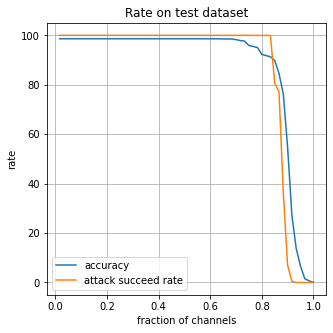

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(frac, cca, label='accuracy')
plt.plot(frac, asr, label='attack succeed rate')
plt.xlabel('fraction of channels')
plt.ylabel('rate')
plt.title('Rate on test dataset')
plt.legend()
plt.grid()

### Whether the pruning defense works for this model?

The prunning defense can work on this model, but the result is not good. Along with the drop of attack success rate, the accuracy almost drops simultaneously. So it is hard to choose the fraction of channels to be pruned. 